<div class="markdown-google-sans">
  <h1>Welcome to Colab!</h1>
</div>

If you're already familiar with Colab, check out this video to learn about interactive tables, the executed code history view, and the command palette.

<center>
  <a href="https://www.youtube.com/watch?v=rNgswRZ2C1Y" target="_blank">
  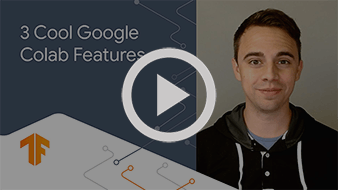
  </a>
</center>

In [1]:
!pip install hdbscan
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import os
import tarfile
import umap.umap_ as umap


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin


import hdbscan
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import random
import re
import seaborn as sns
import string
import torch.cuda
from scipy.optimize import linear_sum_assignment
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.cluster import contingency_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

np.random.seed(42)
random.seed(42)

sns.set_theme()

In [3]:
def plot_matrix(mat, xticklabels, yticklabels, title, **kwargs):
    ax = sns.heatmap(mat, xticklabels=xticklabels, yticklabels=yticklabels, cmap='Blues', annot=True, fmt='d', **kwargs)
    ax.set(xlabel='Predicted label', ylabel='True label', title=title)

In [4]:
def evaluate_clustering(y_true, y_pred, name='', print_evaluation=False):

    homogeneity = metrics.homogeneity_score(y_true, y_pred)
    completeness = metrics.completeness_score(y_true, y_pred)
    v_measure = metrics.v_measure_score(y_true, y_pred)
    adjusted_rand_score = metrics.adjusted_rand_score(y_true, y_pred)
    adjusted_mutual_info_score = metrics.adjusted_mutual_info_score(y_true, y_pred)

    if print_evaluation:
        print(f'Clustering Scores for {name}:')
        print(f'\tHomogeneity: \t\t\t\t{homogeneity:.3f}')
        print(f'\tCompleteness: \t\t\t\t{completeness:.3f}')
        print(f'\tV-measure: \t\t\t\t{v_measure:.3f}')
        print(f'\tAdjusted Rand-Index: \t\t\t{adjusted_rand_score:.3f}')
        print(f'\tAdjusted Mutual Information Score: \t{adjusted_mutual_info_score:.3f}')

    return {
        'homogeneity': homogeneity,
        'completeness': completeness,
        'v_measure': v_measure,
        'adjusted_rand_score': adjusted_rand_score,
        'adjusted_mutual_info_score': adjusted_mutual_info_score
    }

# Part 1 - Clustering on Text Data

##Clustering with Sparse Text Representations


### Generate sparse TF-IDF representations

In [5]:
categories = [
    'comp.graphics',
    'comp.os.ms-windows.misc',
    'comp.sys.ibm.pc.hardware',
    'comp.sys.mac.hardware',
    'rec.autos',
    'rec.motorcycles',
    'rec.sport.baseball',
    'rec.sport.hockey'
]

dataset = fetch_20newsgroups(
    remove=('headers', 'footers'),
    subset='all',
    categories=categories,
    shuffle=True,
    random_state=42,
)

In [6]:
vectorizer = TfidfVectorizer(stop_words='english', min_df=3)
X_tfidf = vectorizer.fit_transform(dataset.data)

In [7]:
X_tfidf.shape

(7882, 23522)

### Clustering with KMeans

In [8]:
kmeans = KMeans(n_clusters=2, max_iter=1000, n_init=30).fit(X_tfidf)

In [9]:
y_all = dataset.target.copy()
y_merged = np.array(list(map(lambda x: 0 if 0 <= x < 4 else 1, y_all)))

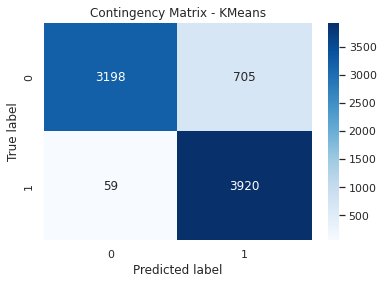

In [10]:
classes = [0, 1]
plot_matrix(contingency_matrix(y_merged, kmeans.labels_), xticklabels=classes, yticklabels=classes, title='Contingency Matrix - KMeans')

In [11]:
raw_metrics = evaluate_clustering(y_merged, kmeans.labels_, name='KMeans', print_evaluation=True)

Clustering Scores for KMeans:
	Homogeneity: 				0.585
	Completeness: 				0.598
	V-measure: 				0.591
	Adjusted Rand-Index: 			0.650
	Adjusted Mutual Information Score: 	0.591


## Clustering with Dense Text Representations

### Generate dense representations for better K-Means Clustering

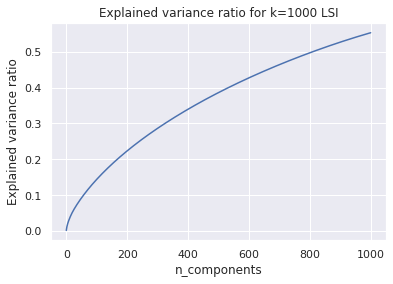

In [12]:
svd = TruncatedSVD(n_components=1000, random_state=42)
X_tfidf_lsi = svd.fit_transform(X_tfidf)
exp_var_ratio_cumsum = np.cumsum(svd.explained_variance_ratio_)
plt.plot(range(len(exp_var_ratio_cumsum)), exp_var_ratio_cumsum)
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('Explained variance ratio for k=1000 LSI')
plt.show()

In [13]:
reductions = ['svd', 'nmf']
reduction__n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]

homogenity_scores = [[], []]
completeness_scores = [[], []]
v_measure_scores = [[], []]
adjusted_rand_scores = [[], []]
adjusted_mutual_info_scores = [[], []]

best_clusters = {}

for i, red in enumerate(reductions):
    
    max_homogeneity = float('-inf')
    best_n_components = -1

    for k in reduction__n_components:
        
        if red == 'svd':
            reduction = TruncatedSVD(n_components=k, random_state=42)
        elif red == 'nmf':
            reduction = NMF(n_components=k, random_state=42)
        X_tfidf_reduced = reduction.fit_transform(X_tfidf)

        kmeans = KMeans(n_clusters=2, max_iter=1000, n_init=30).fit(X_tfidf_reduced)

        cluster_metrics = evaluate_clustering(y_merged, kmeans.labels_)

        if cluster_metrics['homogeneity'] > max_homogeneity:
            max_homogeneity = cluster_metrics['homogeneity']
            best_n_components = k
            best_clusters[red] = kmeans.labels_

        homogenity_scores[i].append(cluster_metrics['homogeneity'])
        completeness_scores[i].append(cluster_metrics['completeness'])
        v_measure_scores[i].append(cluster_metrics['v_measure'])
        adjusted_rand_scores[i].append(cluster_metrics['adjusted_rand_score'])
        adjusted_mutual_info_scores[i].append(cluster_metrics['adjusted_mutual_info_score'])

    print(f'Best k for {red.upper()}: {best_n_components} with homogeneity score {max_homogeneity:.3f}')

Best k for SVD: 300 with homogeneity score 0.577


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed fro

Best k for NMF: 2 with homogeneity score 0.592


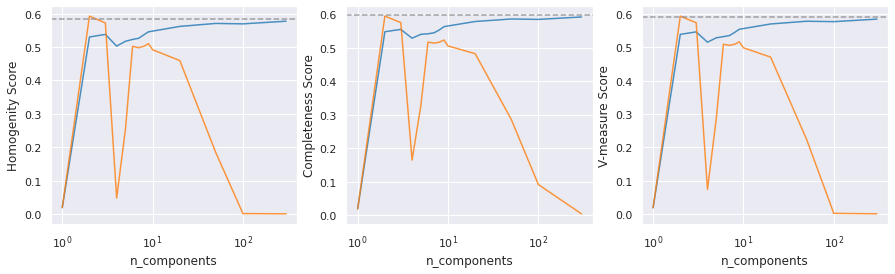

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].plot(reduction__n_components, homogenity_scores[0], label='SVD', c='tab:blue', alpha=0.8)
ax[0].plot(reduction__n_components, homogenity_scores[1], label='NMF', c='tab:orange', alpha=0.8)
ax[0].set_xlabel('n_components')
ax[0].set_ylabel('Homogenity Score')
ax[0].set_xscale('log')
ax[0].axhline(y=raw_metrics['homogeneity'], label='Baseline', c='tab:gray', alpha=0.7, linestyle = '--')

ax[1].plot(reduction__n_components, completeness_scores[0], label='SVD', c='tab:blue', alpha=0.8)
ax[1].plot(reduction__n_components, completeness_scores[1], label='NMF', c='tab:orange', alpha=0.8)
ax[1].set_xlabel('n_components')
ax[1].set_ylabel('Completeness Score')
ax[1].set_xscale('log')
ax[1].axhline(y=raw_metrics['completeness'], label='Baseline', c='tab:gray', alpha=0.7, linestyle = '--')

ax[2].plot(reduction__n_components, v_measure_scores[0], label='SVD', c='tab:blue', alpha=0.8)
ax[2].plot(reduction__n_components, v_measure_scores[1], label='NMF', c='tab:orange', alpha=0.8)
ax[2].set_xlabel('n_components')
ax[2].set_ylabel('V-measure Score')
ax[2].set_xscale('log')
ax[2].axhline(y=raw_metrics['v_measure'], label='Baseline', c='tab:gray', alpha=0.7, linestyle = '--')

plt.show()

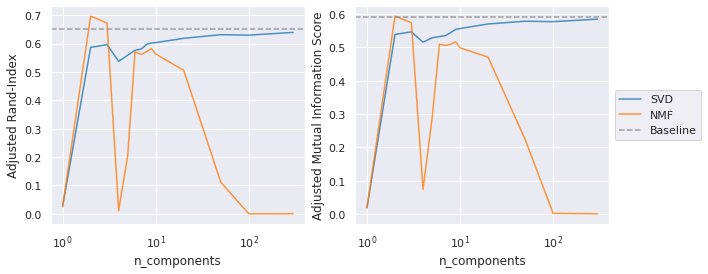

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(reduction__n_components, adjusted_rand_scores[0], label='SVD', c='tab:blue', alpha=0.8)
ax[0].plot(reduction__n_components, adjusted_rand_scores[1], label='NMF', c='tab:orange', alpha=0.8)
ax[0].set_xlabel('n_components')
ax[0].set_ylabel('Adjusted Rand-Index')
ax[0].set_xscale('log')
ax[0].axhline(y=raw_metrics['adjusted_rand_score'], label='Baseline', c='tab:gray', alpha=0.7, linestyle = '--')

ax[1].plot(reduction__n_components, adjusted_mutual_info_scores[0], label='SVD', c='tab:blue', alpha=0.8)
ax[1].plot(reduction__n_components, adjusted_mutual_info_scores[1], label='NMF', c='tab:orange', alpha=0.8)
ax[1].set_xlabel('n_components')
ax[1].set_ylabel('Adjusted Mutual Information Score')
ax[1].set_xscale('log')
ax[1].axhline(y=raw_metrics['adjusted_mutual_info_score'], label='Baseline', c='tab:gray', alpha=0.7, linestyle = '--')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### Visualize the clusters

In [16]:
svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_tfidf)

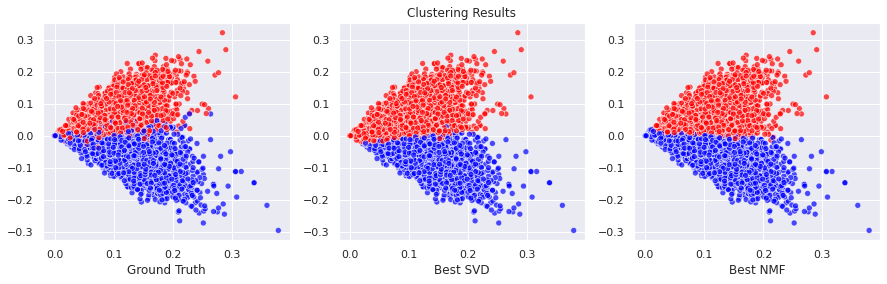

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].scatter(X_2d[:, 0], X_2d[:, 1], c=y_merged, cmap='bwr', edgecolors='w', linewidths=0.75, alpha=0.7)
ax[0].set_xlabel('Ground Truth')

ax[1].scatter(X_2d[:, 0], X_2d[:, 1], c=best_clusters['svd'], cmap='bwr_r', edgecolors='w', linewidths=0.75, alpha=0.7)
ax[1].set_xlabel('Best SVD')
ax[1].set_title('Clustering Results')

ax[2].scatter(X_2d[:, 0], X_2d[:, 1], c=best_clusters['nmf'], cmap='bwr', edgecolors='w', linewidths=0.75, alpha=0.7)
ax[2].set_xlabel('Best NMF')

plt.show()

### Clustering of the Entire 20 Classes

In [18]:
dataset = fetch_20newsgroups(
    remove=('headers', 'footers'),
    subset='all',
    shuffle=True,
    random_state=42,
)

In [19]:
vectorizer = TfidfVectorizer(stop_words='english', min_df=3)
X_tfidf = vectorizer.fit_transform(dataset.data)

In [20]:
X_tfidf.shape

(18846, 45365)

In [21]:
svd = TruncatedSVD(n_components=300, random_state=42)
nmf = NMF(n_components=20, random_state=42)

X_tfidf_svd = svd.fit_transform(X_tfidf)
X_tfidf_nmf = nmf.fit_transform(X_tfidf)

y_all = dataset.target

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [22]:
kmeans_raw = KMeans(n_clusters=20, max_iter=1000, n_init=30).fit(X_tfidf)
kmeans_svd = KMeans(n_clusters=20, max_iter=1000, n_init=30).fit(X_tfidf_svd)
kmeans_nmf = KMeans(n_clusters=20, max_iter=1000, n_init=30).fit(X_tfidf_nmf)

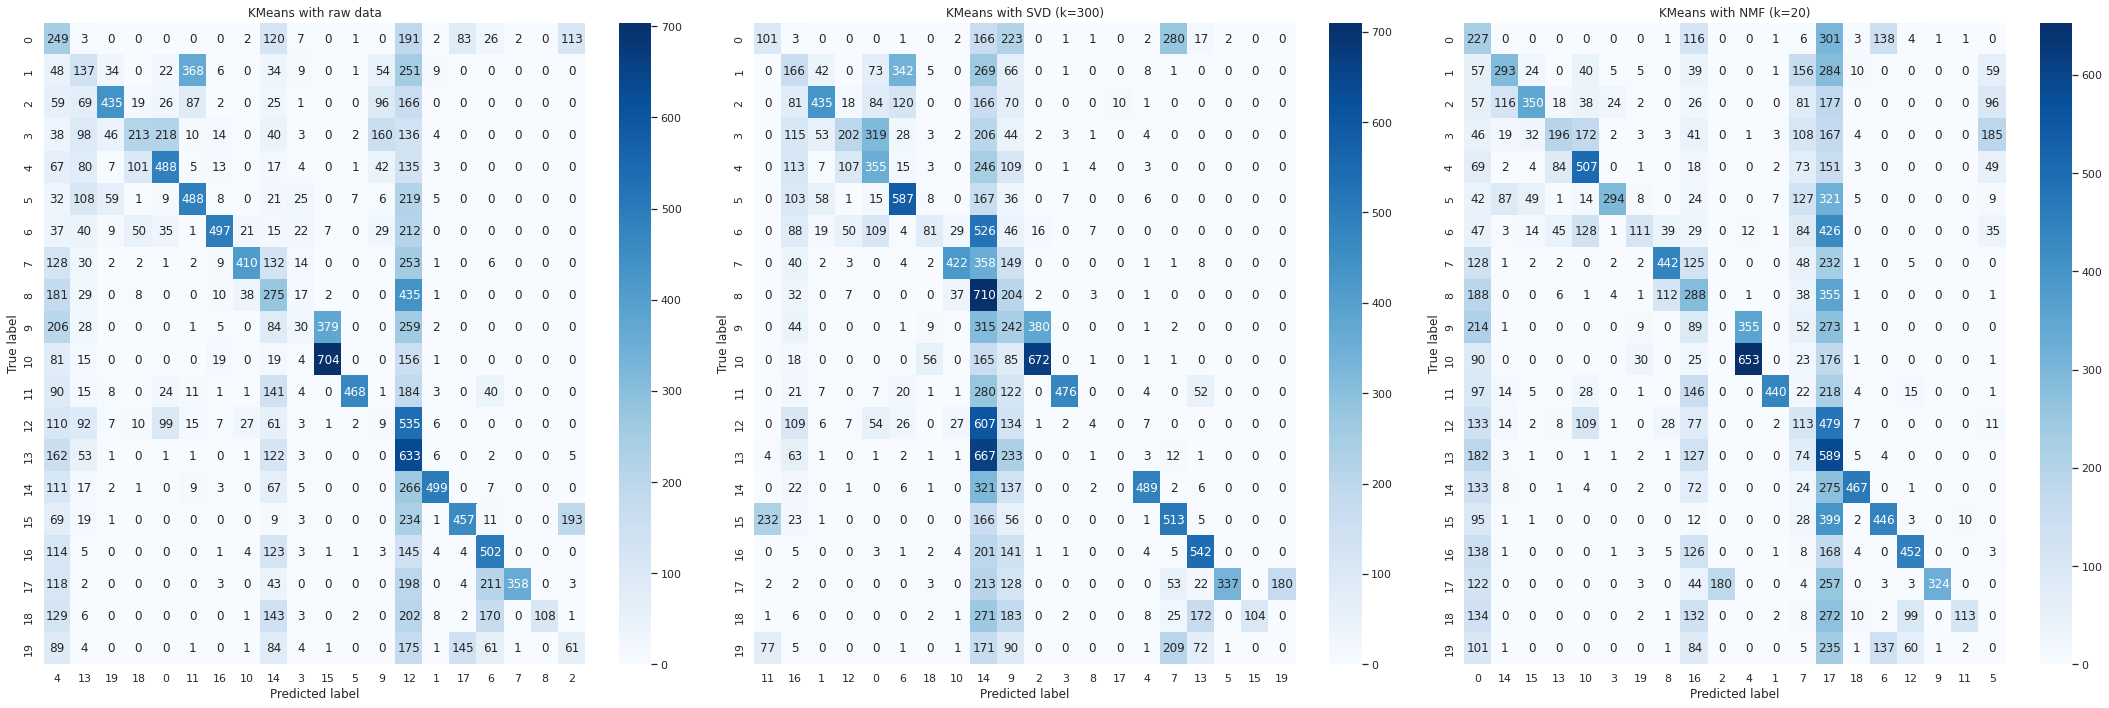

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

cm = contingency_matrix(y_all, kmeans_raw.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_matrix(
    cm[rows[:, np.newaxis], cols], 
    xticklabels=cols, 
    yticklabels=rows, 
    title='KMeans with raw data',
    ax=ax[0]
)

cm = contingency_matrix(y_all, kmeans_svd.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_matrix(
    cm[rows[:, np.newaxis], cols], 
    xticklabels=cols, 
    yticklabels=rows, 
    title='KMeans with SVD (k=300)',
    ax=ax[1]
)

cm = contingency_matrix(y_all, kmeans_nmf.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_matrix(
    cm[rows[:, np.newaxis], cols], 
    xticklabels=cols, 
    yticklabels=rows, 
    title='KMeans with NMF (k=20)',
    ax=ax[2]
)

plt.tight_layout()
plt.show()

In [24]:
raw_metrics = evaluate_clustering(y_all, kmeans_raw.labels_, name='KMeans with raw data', print_evaluation=True)
svd_metrics = evaluate_clustering(y_all, kmeans_svd.labels_, name='KMeans with SVD', print_evaluation=True)
nmf_metrics = evaluate_clustering(y_all, kmeans_nmf.labels_, name='KMeans with NMF', print_evaluation=True)

Clustering Scores for KMeans with raw data:
	Homogeneity: 				0.356
	Completeness: 				0.409
	V-measure: 				0.381
	Adjusted Rand-Index: 			0.128
	Adjusted Mutual Information Score: 	0.378
Clustering Scores for KMeans with SVD:
	Homogeneity: 				0.340
	Completeness: 				0.428
	V-measure: 				0.379
	Adjusted Rand-Index: 			0.107
	Adjusted Mutual Information Score: 	0.377
Clustering Scores for KMeans with NMF:
	Homogeneity: 				0.314
	Completeness: 				0.377
	V-measure: 				0.343
	Adjusted Rand-Index: 			0.088
	Adjusted Mutual Information Score: 	0.340


### UMAP

In [25]:
import umap.umap_ as umap

Clustering Scores for KMeans with UMAP (k=5, metric='cosine'):
	Homogeneity: 				0.576
	Completeness: 				0.597
	V-measure: 				0.586
	Adjusted Rand-Index: 			0.459
	Adjusted Mutual Information Score: 	0.585
Clustering Scores for KMeans with UMAP (k=20, metric='cosine'):
	Homogeneity: 				0.576
	Completeness: 				0.603
	V-measure: 				0.589
	Adjusted Rand-Index: 			0.467
	Adjusted Mutual Information Score: 	0.588
Clustering Scores for KMeans with UMAP (k=200, metric='cosine'):
	Homogeneity: 				0.559
	Completeness: 				0.593
	V-measure: 				0.575
	Adjusted Rand-Index: 			0.428
	Adjusted Mutual Information Score: 	0.574
Clustering Scores for KMeans with UMAP (k=5, metric='euclidean'):
	Homogeneity: 				0.007
	Completeness: 				0.007
	V-measure: 				0.007
	Adjusted Rand-Index: 			0.001
	Adjusted Mutual Information Score: 	0.003
Clustering Scores for KMeans with UMAP (k=20, metric='euclidean'):
	Homogeneity: 				0.006
	Completeness: 				0.006
	V-measure: 				0.006
	Adjusted Rand-Index: 		

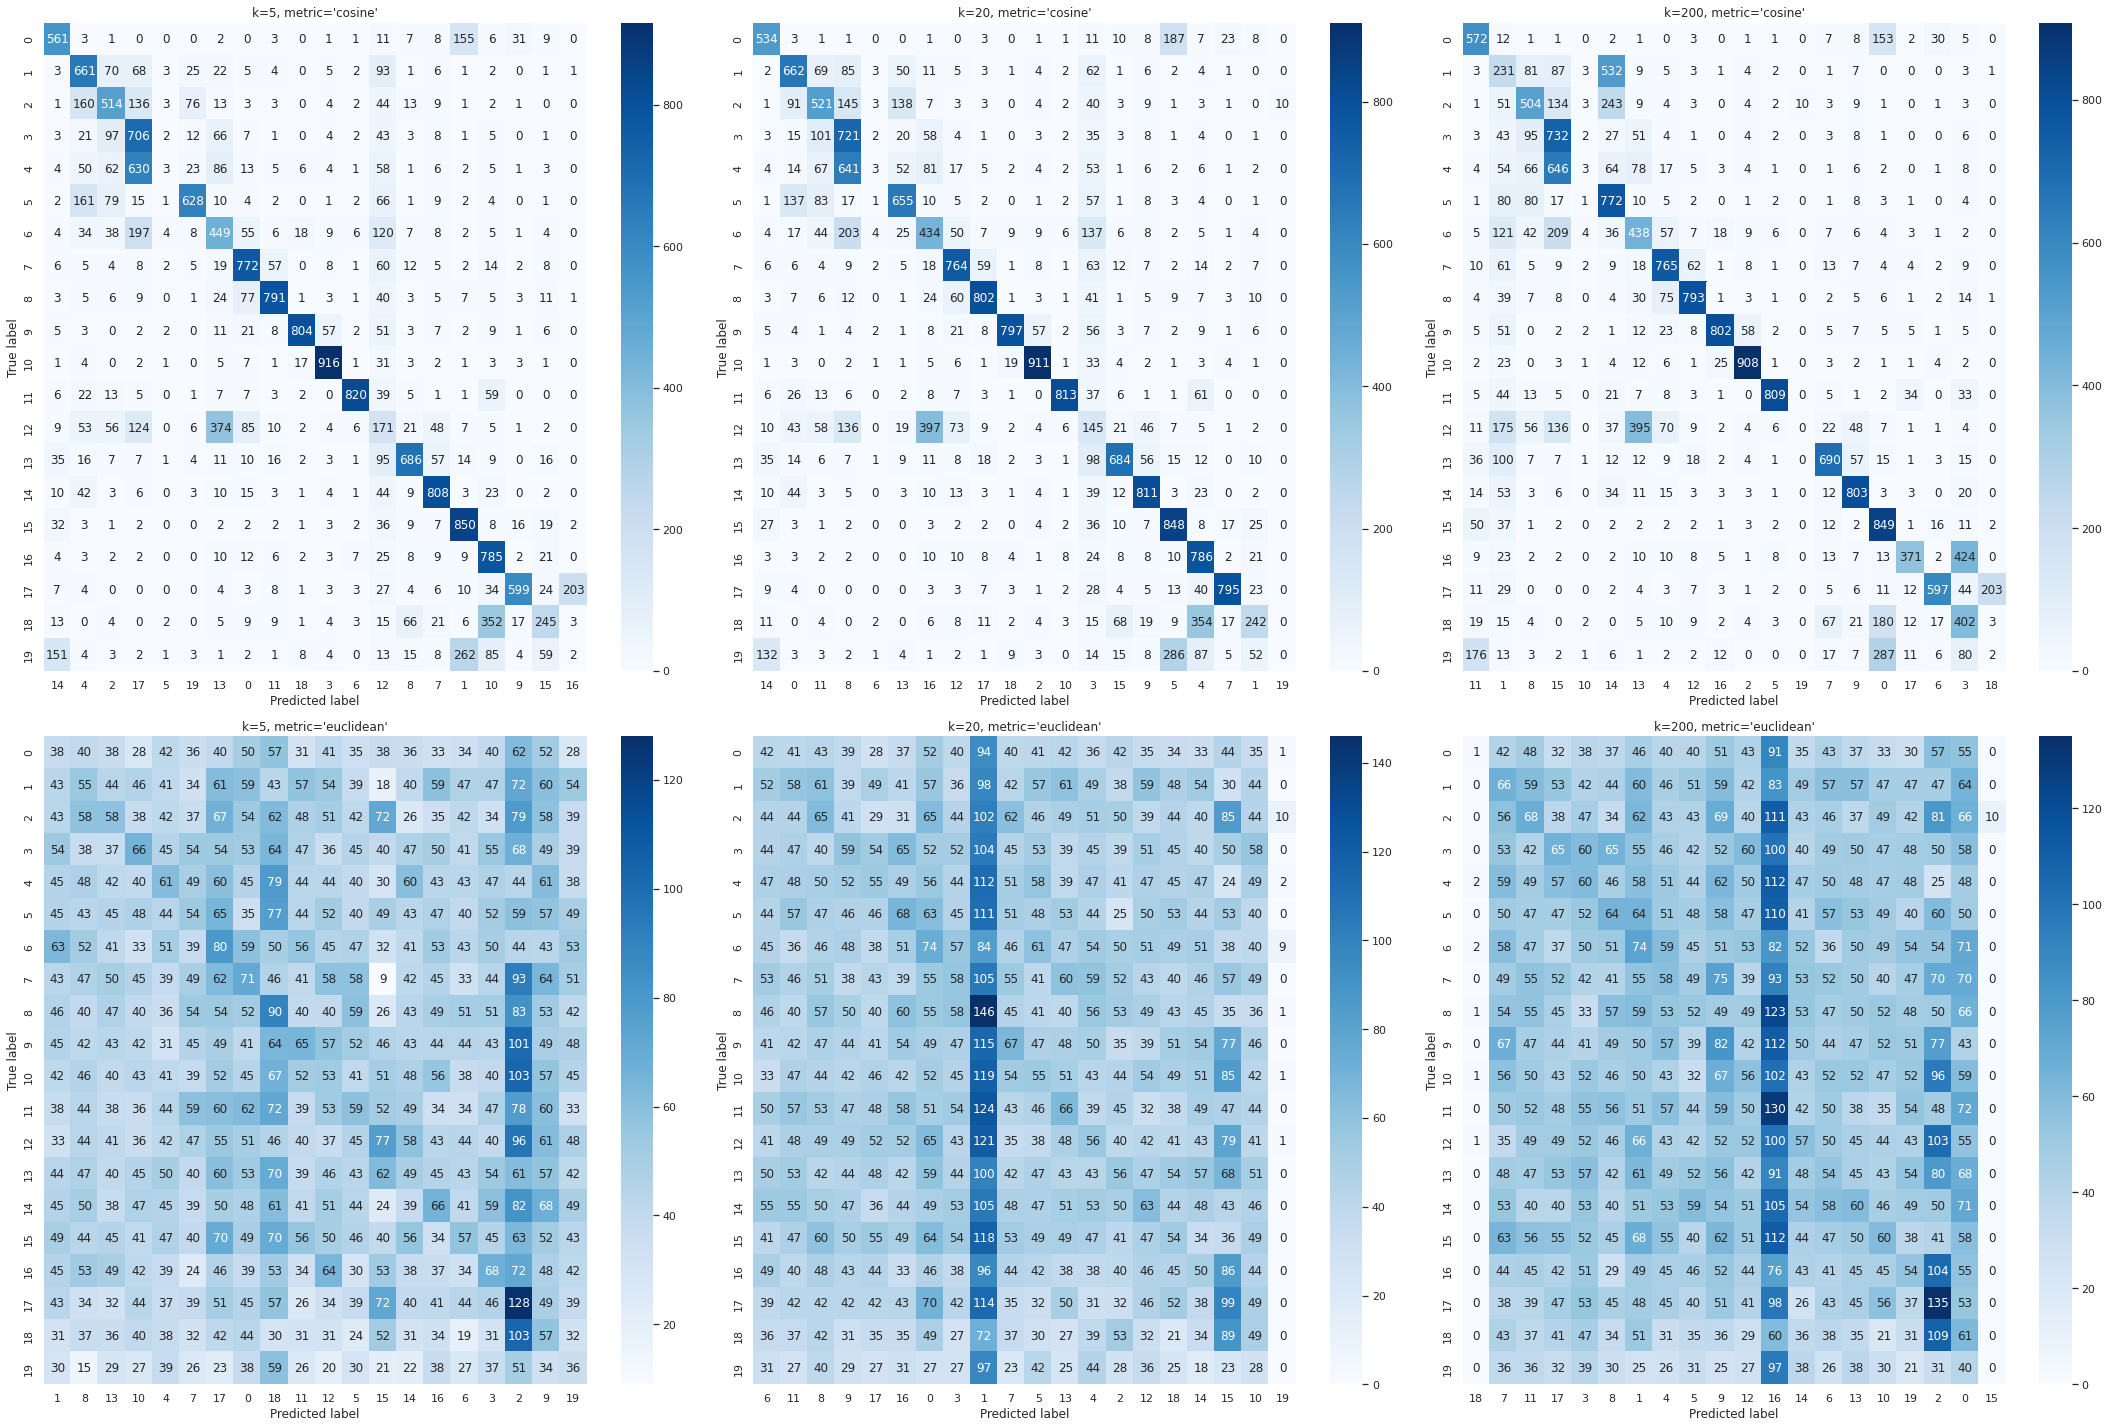

In [26]:
fig, ax = plt.subplots(2, 3, figsize=(30, 20))

reduction__n_components = [5, 20, 200]
reduction__metric = ['cosine', 'euclidean']

for i, metric in enumerate(reduction__metric):
    for j, k in enumerate(reduction__n_components):
        umap_reducer = umap.UMAP(n_components=k, metric=metric, random_state=42)
        X_tfidf_umap = umap_reducer.fit_transform(X_tfidf)

        kmeans_umap = KMeans(n_clusters=20, max_iter=1000, n_init=30).fit(X_tfidf_umap)

        cm = contingency_matrix(y_all, kmeans_umap.labels_)
        rows, cols = linear_sum_assignment(cm, maximize=True)
        plot_matrix(
            cm[rows[:, np.newaxis], cols], 
            xticklabels=cols, 
            yticklabels=rows, 
            title=f'{k=}, {metric=}',
            ax=ax[i][j]
        )

        evaluate_clustering(y_all, kmeans_umap.labels_, name=f'KMeans with UMAP ({k=}, {metric=})', print_evaluation=True)

plt.tight_layout()
plt.show()

## Clustering Algorithms that do not explicitly rely on the Gaussian distribution per cluster

### Agglomerative Clustering

In [27]:
best_umap = umap.UMAP(n_components=20, metric='cosine', random_state=42)
X_tfidf_umap = best_umap.fit_transform(X_tfidf)

agglomerative_ward = AgglomerativeClustering(n_clusters=20, linkage='ward').fit(X_tfidf_umap)
agglomerative_single = AgglomerativeClustering(n_clusters=20, linkage='single').fit(X_tfidf_umap)

In [28]:
evaluate_clustering(y_all, agglomerative_ward.labels_, name='Agglomerative Clustering with linkage=\'ward\'', print_evaluation=True)
_ = evaluate_clustering(y_all, agglomerative_single.labels_, name='Agglomerative Clustering with linkage=\'single\'', print_evaluation=True)

Clustering Scores for Agglomerative Clustering with linkage='ward':
	Homogeneity: 				0.553
	Completeness: 				0.594
	V-measure: 				0.573
	Adjusted Rand-Index: 			0.419
	Adjusted Mutual Information Score: 	0.572
Clustering Scores for Agglomerative Clustering with linkage='single':
	Homogeneity: 				0.017
	Completeness: 				0.381
	V-measure: 				0.032
	Adjusted Rand-Index: 			0.001
	Adjusted Mutual Information Score: 	0.027


### HDBSCAN

In [29]:
for min_cluster_size in [20, 100, 200]:
    hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size).fit(X_tfidf_umap)
    evaluate_clustering(y_all, hdb.labels_, name=f'HDBSCAN with {min_cluster_size=}', print_evaluation=True)

Clustering Scores for HDBSCAN with min_cluster_size=20:
	Homogeneity: 				0.000
	Completeness: 				0.080
	V-measure: 				0.001
	Adjusted Rand-Index: 			0.000
	Adjusted Mutual Information Score: 	0.000
Clustering Scores for HDBSCAN with min_cluster_size=100:
	Homogeneity: 				0.411
	Completeness: 				0.620
	V-measure: 				0.494
	Adjusted Rand-Index: 			0.223
	Adjusted Mutual Information Score: 	0.493
Clustering Scores for HDBSCAN with min_cluster_size=200:
	Homogeneity: 				0.413
	Completeness: 				0.608
	V-measure: 				0.492
	Adjusted Rand-Index: 			0.209
	Adjusted Mutual Information Score: 	0.491


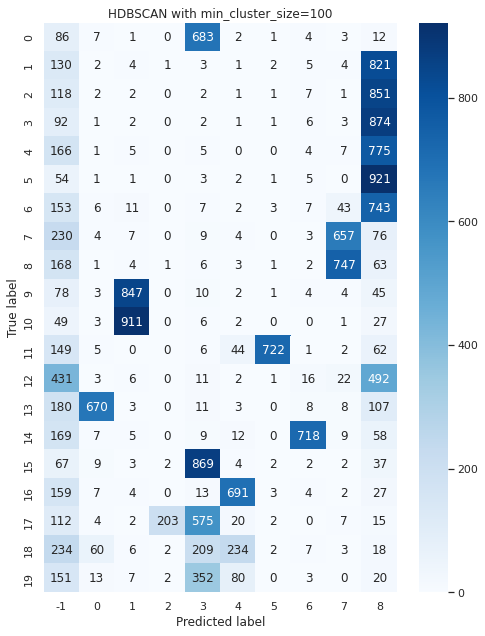

In [30]:
hdb_best = hdbscan.HDBSCAN(min_cluster_size=100).fit(X_tfidf_umap)

plt.figure(figsize=(7, 9))
cm = contingency_matrix(y_all, hdb_best.labels_)
plot_matrix(
    cm, 
    xticklabels=sorted(np.unique(hdb_best.labels_)), 
    yticklabels=range(20), 
    title='HDBSCAN with min_cluster_size=100'
)

plt.tight_layout()
plt.show()

# Part 2 - Deep Learning and Clustering of Image Data

## Helper Code

### Flowers Dataset and VGG Features

# Load dataset

In [31]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    print('if run')
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out) 
            return out 

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on f_all, y_all
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    print('else run')
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

if run


In [32]:
print("f_all shape: ", f_all.shape, ", y_all shape: ", y_all.shape)
print("Number of features: ", f_all.shape[1])

f_all shape:  (3670, 4096) , y_all shape:  (3670,)
Number of features:  4096


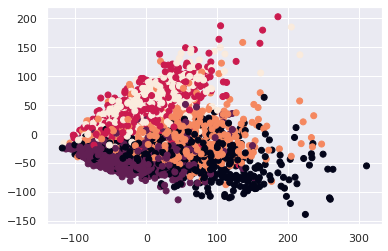

In [33]:
f_pca = PCA(n_components=2).fit_transform(f_all)
plt.scatter(*f_pca.T, c=y_all)

## Q22

In [34]:
from scipy.sparse import csr_matrix

In [35]:
X_tfidf_sparse = csr_matrix(X_tfidf)
print("Non_zero_elements in TF-IDF = ", X_tfidf_sparse.nnz)
f_all_sparse = csr_matrix(f_all)
print("Non_zero_elements in f_all = ", f_all_sparse.nnz)

Non_zero_elements in TF-IDF =  1553673
Non_zero_elements in f_all =  15032320


## Q23

In [36]:
from sklearn.manifold import TSNE

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


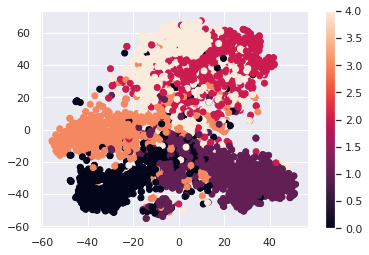

In [37]:
# Initialize t-SNE
tsne = TSNE(n_components=2)

# Fit t-SNE 
X_tsne = tsne.fit_transform(f_all)

# Plot 
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_all)
plt
plt.colorbar()
plt.show()

# Autoencoder

In [38]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None
        
    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))
    
    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))
    
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    
    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self     
        
    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

## Q24

### none

In [39]:
#without dimensionality redution
kmeans = KMeans(n_clusters=5, max_iter=1000, n_init=30)

In [40]:
y_pred = kmeans.fit_predict(f_all)

In [41]:
rand_ind = metrics.adjusted_rand_score(y_all,y_pred)
print("Adjusted Rand Index: \t\t", rand_ind)

Adjusted Rand Index: 		 0.19149424860310876


In [72]:
#kmeans = KMeans(n_clusters=2, max_iter=1000, n_init=30).fit(X_tfidf)
#y_all = dataset.target.copy()
#y_merged = np.array(list(map(lambda x: 0 if 0 <= x < 4 else 1, y_all)))

In [73]:
#raw_metrics = evaluate_clustering(y_merged, kmeans.labels_, name='KMeans', print_evaluation=True)

### svd

In [44]:
f_all, y_all = file['f_all'], file['y_all']
X_svd_vgg = TruncatedSVD(n_components=50).fit_transform(f_all)

y_pred_svd = KMeans(n_clusters=2, max_iter=1000, n_init=30).fit_predict(X_svd_vgg)

rand_ind_svd = metrics.adjusted_rand_score(y_all,y_pred_svd)
print("Adjusted Rand Index: \t\t", rand_ind_svd)

Adjusted Rand Index: 		 0.05422298383079642


In [75]:
#X_svd_vgg = TruncatedSVD(n_components=50).fit_transform(f_all)

#y_pred_svd = kmeans.fit_predict(X_svd_vgg)

#rand_ind_svd = metrics.adjusted_rand_score(y_all,y_pred_svd)
#print("Adjusted Rand Index: \t\t", rand_ind_svd)

In [74]:
#y_all = dataset.target.copy()
#y_merged = np.array(list(map(lambda x: 0 if 0 <= x < 4 else 1, y_all)))

#svd = TruncatedSVD(n_components=50, random_state=42)
#X_tfidf_lsi = svd.fit_transform(X_tfidf)


#kmeans_raw = KMeans(n_clusters=2, max_iter=1000, n_init=30).fit(X_tfidf_lsi)
#cluster_metrics = evaluate_clustering(y_merged, kmeans_raw.labels_)
#cluster_metrics

### umap

In [47]:
f_all, y_all = file['f_all'], file['y_all']
reduction__metric = ['cosine', 'euclidean']
for j in reduction__metric:
  
  umap_vgg_embedding = umap.UMAP(n_components=50, metric=j).fit_transform(f_all)
  y_pred_umap = kmeans.fit_predict(umap_vgg_embedding)

  rand_ind_umap = metrics.adjusted_rand_score(y_all,y_pred_umap)
  print("Adjusted Rand Index: \t\t", rand_ind_umap,"with metric ",j)

Adjusted Rand Index: 		 0.0953565808444732 with metric  cosine
Adjusted Rand Index: 		 0.29758348410179175 with metric  euclidean


In [81]:
#f_all, y_all = file['f_all'], file['y_all']
#reduction__metric = ['cosine', 'euclidean']
#for j in reduction__metric:
  
  #umap_vgg_embedding = umap.UMAP(n_components=50, metric=j).fit_transform(f_all)
  #y_pred_umap = KMeans(n_clusters=2, max_iter=1000, n_init=30).fit_predict(umap_vgg_embedding)

  #rand_ind_umap = metrics.adjusted_rand_score(y_all,y_pred_umap)
  #print("Adjusted Rand Index: \t\t", rand_ind_umap,"with metric ",j)

In [77]:
#y_all = dataset.target.copy()
#umap_reducer = umap.UMAP(n_components=50, metric='cosine', random_state=42)
#X_tfidf_umap = umap_reducer.fit_transform(X_tfidf)
#kmeans_umap = KMeans(n_clusters=2, max_iter=1000, n_init=30).fit(X_tfidf_umap)

#evaluate_clustering(y_all, kmeans_umap.labels_, print_evaluation=True)

### Autoencoder

In [66]:
f_all, y_all = file['f_all'], file['y_all']
X_auto_vgg = Autoencoder(50).fit_transform(f_all)

y_pred_auto = kmeans.fit_predict(X_auto_vgg)

rand_ind_auto = metrics.adjusted_rand_score(y_all,y_pred_auto)
print("Adjusted Rand Index: \t\t", rand_ind_auto)

100%|██████████| 100/100 [00:23<00:00,  4.32it/s]


Adjusted Rand Index: 		 0.04088088193782818


### kmeans

In [51]:
f_all, y_all = file['f_all'], file['y_all']
umap_vgg_embedding1 = umap.UMAP(n_components=50, metric='cosine').fit_transform(f_all)
kmeans_new = KMeans(
    n_clusters=5,
    random_state=0,
    max_iter=1000,
    n_init=30
)
y_pred_km = kmeans_new.fit_predict(umap_vgg_embedding1)

rand_ind_km = metrics.adjusted_rand_score(y_all,y_pred_km)
print("Adjusted Rand Index: \t\t", rand_ind_km)

Adjusted Rand Index: 		 0.465997323695121


In [78]:
#y_all = dataset.target.copy()
#umap_vgg_embedding1 = umap.UMAP(n_components=50, metric='cosine').fit_transform(X_tfidf)
#kmeans_new = KMeans(
    #n_clusters=5,
    #random_state=0,
    #max_iter=1000,
    #n_init=30
#)
#y_pred_km = kmeans_new.fit_predict(umap_vgg_embedding1)

#rand_ind_km = metrics.adjusted_rand_score(y_all,y_pred_km)
#print("Adjusted Rand Index: \t\t", rand_ind_km)

### Agglomerative Clustering

In [53]:
f_all, y_all = file['f_all'], file['y_all']
umap_vgg = umap.UMAP(n_components=50, metric='cosine')
umap_vgg_embedding1 = umap_vgg.fit_transform(f_all)
agg_ward_5 = AgglomerativeClustering(
    n_clusters= 5,
    linkage='ward'
)
y_pred_agg = agg_ward_5.fit_predict(umap_vgg_embedding1)

rand_ind_agg = metrics.adjusted_rand_score(y_all,y_pred_agg)
print("Adjusted Rand Index: \t\t", rand_ind_agg)

agg_ward_5 = AgglomerativeClustering(
    n_clusters= 5,
    linkage='single'
)
y_pred_agg = agg_ward_5.fit_predict(umap_vgg_embedding1)

rand_ind_agg = metrics.adjusted_rand_score(y_all,y_pred_agg)
print("Adjusted Rand Index: \t\t", rand_ind_agg)

Adjusted Rand Index: 		 0.48633282871717937
Adjusted Rand Index: 		 0.0944919422703709


In [79]:
#best_umap = umap.UMAP(n_components=50, metric='cosine', random_state=42)
#f_all = best_umap.fit_transform(f_all)

#agglomerative_ward = AgglomerativeClustering(n_clusters=5, linkage='ward').fit(f_all)
#agglomerative_single = AgglomerativeClustering(n_clusters=5, linkage='single').fit(f_all)

#evaluate_clustering(y_all, agglomerative_ward.labels_, name='Agglomerative Clustering with linkage=\'ward\'', print_evaluation=True)
#_ = evaluate_clustering(y_all, agglomerative_single.labels_, name='Agglomerative Clustering with linkage=\'single\'', print_evaluation=True)

### HDBSCAN

In [69]:
min_cluster_size_list = [10,20, 50, 100,170,200]
min_samples_list = [None,1,3]
f_all, y_all = file['f_all'], file['y_all']
mcs_list=min_cluster_size_list
ms_list=min_samples_list

In [70]:
def hdbscan_vgg(umap_embedding,label,mcs_list,ms_list):
  for mcs in mcs_list:
    for ms in ms_list:
      print("==== HDBSCAN min_cluster_size = {}, min_samples = {} ====".format(mcs,ms))

      hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=mcs,min_samples=ms)
      y_pred_hdbscan = hdbscan_model.fit_predict(umap_embedding)
      
      adjusted_rand_index_hdbscan = metrics.adjusted_rand_score(label,y_pred_hdbscan)
      print("Adjusted Rand Index: \t\t", adjusted_rand_index_hdbscan)
     

In [71]:
hdbscan_vgg(umap_vgg_embedding,y_all,min_cluster_size_list,min_samples_list)

==== HDBSCAN min_cluster_size = 10, min_samples = None ====
Adjusted Rand Index: 		 0.20996545156480037
==== HDBSCAN min_cluster_size = 10, min_samples = 1 ====
Adjusted Rand Index: 		 0.049658412398940345
==== HDBSCAN min_cluster_size = 10, min_samples = 3 ====
Adjusted Rand Index: 		 0.043525336714732486
==== HDBSCAN min_cluster_size = 20, min_samples = None ====
Adjusted Rand Index: 		 0.14495361765794468
==== HDBSCAN min_cluster_size = 20, min_samples = 1 ====
Adjusted Rand Index: 		 0.0900292653093549
==== HDBSCAN min_cluster_size = 20, min_samples = 3 ====
Adjusted Rand Index: 		 0.07822717910011942
==== HDBSCAN min_cluster_size = 50, min_samples = None ====
Adjusted Rand Index: 		 0.2415437284085123
==== HDBSCAN min_cluster_size = 50, min_samples = 1 ====
Adjusted Rand Index: 		 0.27187968033356125
==== HDBSCAN min_cluster_size = 50, min_samples = 3 ====
Adjusted Rand Index: 		 0.1410229678041831
==== HDBSCAN min_cluster_size = 100, min_samples = None ====
Adjusted Rand Index: 	

## Q25

### MLP Classifier

In [59]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), 
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()
    
    
    def forward(self, X):
        return self.model(X)
    
    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                

                X_ = X_.cuda()
              
                output = self(X_)
              
                loss = criterion(output,y_.cuda())

                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        return self
    
    def eval(self, X_test, y_test):
        X_pred = self(torch.tensor(X_test,dtype=torch.float32, device='cuda'))
        logit = X_pred.argmax(dim=1)
  
        # accuracy
        acc = torch.sum(logit == torch.tensor(y_test,dtype=torch.float32, device='cuda'))/X_test.shape[0]
        with torch.no_grad():
          acc = acc.cpu().numpy()
        return acc


In [60]:
f_all, y_all = file['f_all'], file['y_all']
X_train, X_test, y_train, y_test = train_test_split(f_all, y_all, test_size=0.2, random_state=42)

In [61]:
model = MLP(4096)
print("Using original VGG features.\n")
model.train(X_train, y_train)
acc = model.eval(X_test, y_test)
print(f"\nAccuracy: {acc}")

Using original VGG features.



100%|██████████| 100/100 [00:08<00:00, 11.48it/s]



Accuracy: 0.9141689538955688


In [62]:
def umap_dl_model(n_component, f_all, y_all):
  umap_feature = umap.UMAP(n_components=n_component, metric='cosine')
  umap_feature_embedding = umap_feature.fit_transform(f_all)

  model = MLP(n_component)
  X_train, X_test, y_train, y_test = train_test_split(umap_feature_embedding, y_all, test_size=0.2, random_state=42)
  model.train(X_train, y_train)
  acc = model.eval(X_test, y_test)
  print(f"Dimension: {n_component} Accuracy: {acc}\n")
  return acc

In [63]:
print("Using UMAP as dimension reduction method.\n")
acc_umap_200 = umap_dl_model(200, f_all, y_all)
acc_umap_100 = umap_dl_model(100, f_all, y_all)
acc_umap_50 = umap_dl_model(50, f_all, y_all)
acc_umap_20 = umap_dl_model(20, f_all, y_all)
acc_umap_10 = umap_dl_model(10, f_all, y_all)
acc_umap_5 = umap_dl_model(5, f_all, y_all)
acc_umap_2 = umap_dl_model(2, f_all, y_all)

Using UMAP as dimension reduction method.



100%|██████████| 100/100 [00:06<00:00, 14.40it/s]


Dimension: 200 Accuracy: 0.829700231552124



100%|██████████| 100/100 [00:07<00:00, 13.41it/s]


Dimension: 100 Accuracy: 0.8365122675895691



100%|██████████| 100/100 [00:07<00:00, 13.33it/s]


Dimension: 50 Accuracy: 0.8542234301567078



100%|██████████| 100/100 [00:06<00:00, 14.54it/s]


Dimension: 20 Accuracy: 0.8651226162910461



100%|██████████| 100/100 [00:07<00:00, 13.68it/s]


Dimension: 10 Accuracy: 0.8678473830223083



100%|██████████| 100/100 [00:07<00:00, 13.78it/s]


Dimension: 5 Accuracy: 0.8692098259925842



100%|██████████| 100/100 [00:07<00:00, 13.89it/s]

Dimension: 2 Accuracy: 0.8337874412536621

